In [1]:
import vaex as vx
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import scipy as sc
from scipy.interpolate import PchipInterpolator as minterp
import scipy.stats as stats
import seaborn as sns
from matplotlib import pyplot as plt
import ipyvolume as ipv
import plotly
import plotly.graph_objs as go
# Configure Plotly to be rendered inline in the notebook.

plotly.offline.init_notebook_mode(connected=True)

from tqdm import tqdm

import os
import sys
import re
import gc
from numba import jit
from collections import Counter
from collections import namedtuple
from collections import defaultdict

from sklearn.covariance import OAS
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import LedoitWolf
from sklearn.covariance import EmpiricalCovariance

import tensorflow as tf

from umap import UMAP
from sklearn.manifold import MDS
from sklearn.decomposition import PCA, MiniBatchDictionaryLearning as DL, NMF, FastICA as ICA, FactorAnalysis as FA, SparsePCA as SPCA

from _helpers import _helpers as hlp


from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgbm
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier as HB
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC

from xgboost import XGBRegressor as xgbr
from lightgbm import LGBMRegressor as lgbmr
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, HuberRegressor, ARDRegression
from pygam import GAM, LinearGAM, s, f, l, te
from ngboost import NGBRegressor as ngbr
from ngboost.distns import LogNormal, Normal,Bernoulli
from ngboost.learners import default_tree_learner
from pyearth import Earth
from interpret.glassbox import ExplainableBoostingRegressor as ebr

from sklearn.inspection import permutation_importance, partial_dependence, plot_partial_dependence
from shap import TreeExplainer, force_plot, dependence_plot, summary_plot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score, average_precision_score, mean_squared_log_error, mean_squared_error
from sklearn.cluster import AffinityPropagation

from scipy.stats import spearmanr, pearsonr
from scipy.spatial.distance import cdist
from scipy.cluster import hierarchy

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/usr/local/lib/p

In [2]:
# Load gene list
genes = pd.read_csv('../_meta_data/gene_types/selected_genes.csv', sep='\t')
genes.Symbol = genes.Symbol.str.upper()

In [3]:
os.chdir('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/')

We start with RNA expression, methylation and DNA mutations separately.

The differentiation targets are the treatment response, the cancer types and the tissue type.

We use :

* statistical difference
* geometric difference
* multivariate classification

# Load data

In [4]:
# RNA 
# Methylation
# mutation
# Load meta data: immunoresponse, age, gender

dd = {}
dd['RNAex'] = vx.open('Lung_GeneExpression.hdf5')
dd['mutation'] = vx.open('Lung_Mutation.hdf5')
dd['methylation'] = vx.open('Lung_Methylation.hdf5')
dd['methylation_meta'] = vx.open('HumanMethylation450_meta.hdf5')
dd['CNV'] = vx.open('Lung_CNV.hdf5')

miRNA = pd.read_csv('Lung_miRNA.txt', sep="\t")
mimamap = miRNA[['MIMATID', 'Name', 'Chr', 'Start', 'Stop', 'Strand']]
miRNA.drop(['Name', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
miRNA = miRNA.set_index('MIMATID').transpose()

proteome = pd.read_csv("Lung_Proteome.txt", sep="\t")
proteome = proteome.set_index('sample').transpose()

meta = pd.read_csv('Lung_Phenotype_Metadata.txt', sep='\t')
meta = meta.loc[~pd.isna(meta.Diagnosis)]
meta = meta[~meta.SampleID.duplicated(keep='last')]
meta['SampleID']  = meta.SampleID.str.replace("\-", "_")
meta.set_index('SampleID', inplace=True)

In [5]:
granzyms = list(set(dd['RNAex'][dd['RNAex'].Gene.str.contains('(GZM)|(SECT)|(PRF)')].Gene.tolist()))
tmp = pd.DataFrame([{'Symbol':_int, 'gene_class': 'granzyms'} for _int in granzyms])
genes = pd.concat([genes, tmp])

In [6]:
interferons = list(set(dd['RNAex'][dd['RNAex'].Gene.str.contains('IFN')].Gene.tolist()))
tmp = pd.DataFrame([{'Symbol':_int, 'gene_class': 'interferon'} for _int in interferons])
genes = pd.concat([genes, tmp])

In [7]:
meta_cols = ['Gender', 'Diagnosis', 'Age At Diagnosis (Years)', 
             'Overall Survival Status', 'Pack Years', 'Smoking Status',
             'Time To Overall Survival (Days)']
meta_cols = meta_cols + ['New Tumor Event', 'Radiation Therapy', 'Reponse To Therapy', 'Drug Therapy Type']

stage_map = {'stage i': 'stage 1', 'stage ia': 'stage 1', 'stage ib': 'stage 1',
             'stage ii': 'stage 2', 'stage iia': 'stage 2', 'stage iib': 'stage 2',
             'stage iii': 'stage 3','stage iiia': 'stage 3', 'stage iiib': 'stage 3',
             'stage iv' : 'stage 4'}
meta['Stage'] = meta['Tumor Stage'].map(stage_map)
########
smoke_map = {'Current Reformed Smoker < or = 15 yrs': 'reformed', 
             'Current Reformed Smoker for > 15 yrs': 'reformed',
             'Current Reformed Smoker, Duration Not Specified': 'reformed',
             'Current Smoker': 'current',
             'Lifelong Non-Smoker': 'non-smoker'}
meta['Smoking'] = meta['Smoking Status'].map(smoke_map)
########
response_map = {'Progressive Disease': 0,
                'Complete Remission/Response': 1,
                'Stable Disease': 0,
                'Partial Remission/Response': 1}
meta['Response'] = meta['Reponse To Therapy'].map(response_map)

meta['Overall Survival Status'] =  meta['Overall Survival Status'].astype(int)

gender_map = {'male': 0, 'female': 1}
meta['Gender'] = meta['Gender'].map(gender_map)

meta_cols = list(set(meta_cols + ['Stage', 'Smoking', 'Response', 'Sample Type']))

# 1. Univariate expression diff

* RNA expression
* Methylation
* DNA mutation
* CNV
* micro-RNA
* proteomes

Diff of:
* Diagnosis
* Sample type
* Response

In [8]:
dd['RNAex'].Gene = dd['RNAex'].Gene.str.upper()
RNAex = dd['RNAex'].to_pandas_df()
RNAex = RNAex.loc[RNAex.Gene.isin(genes.Symbol)]
RNAex.sort_values(by='Gene', inplace=True)
RNAex.Start = RNAex.Start.astype(str)
RNAex.Stop = RNAex.Stop.astype(str)
RNAex['rnaID'] = RNAex[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x: "_".join(x), axis=1)
rnamap = RNAex[['rnaID', 'Gene', 'Chr', 'Start', 'Stop', 'Strand']]
rnamap['rnaID'].reset_index(drop=True, inplace=True)
RNAex.drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
RNAex = RNAex.set_index('rnaID').transpose()
gc.collect()

28726

In [10]:
low_var_list = RNAex.loc[:, rnamap['rnaID']].columns[RNAex.loc[:, rnamap['rnaID']].var()<0.05].tolist()
rnaID_include = list(set(rnamap.rnaID) - set(low_var_list))

In [11]:
dd['mutation'].Gene = dd['mutation'].Gene.str.upper()
mutation = dd['mutation'].to_pandas_df()
mutation = mutation.loc[mutation.Gene.isin(genes.Symbol)]
mutation.set_index('Sample_ID', inplace=True)
gc.collect()

6

In [12]:
dd['methylation'].Gene = dd['methylation'].Gene.str.upper()
methylation = dd['methylation'].to_pandas_df()
methylation = methylation.loc[methylation.Gene.isin(genes.Symbol)]
probemap = methylation[['probeID', 'Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island']]
probemap.reset_index(drop=True, inplace=True)
methylation.drop(['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island'], axis=1, inplace=True)
methylation = methylation.set_index('probeID').transpose()
gc.collect()

5

In [13]:
methylation_meta = dd['methylation_meta'].to_pandas_df()
methylation_meta = methylation_meta.loc[methylation_meta.IlmnID.isin(methylation.columns)]
gc.collect()

0

In [14]:
dd['CNV'].Gene = dd['CNV'].Gene.str.upper()
CNV = dd['CNV'].to_pandas_df()
CNV = CNV.loc[CNV.Gene.isin(genes.Symbol)]
CNV.Start = CNV.Start.astype(str)
CNV.Stop = CNV.Stop.astype(str)
CNV.Start.fillna("nan", inplace=True)
CNV.Stop.fillna("nan", inplace=True)
CNV.Strand.fillna("nan", inplace=True)
CNV.Chr.fillna("nan", inplace=True)
CNV['cnvID'] = CNV[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x: "_".join(x), axis=1)
cnvmap = CNV[['cnvID', 'Gene', 'Chr', 'Start', 'Stop', 'Strand']]
cnvmap.reset_index(drop=True, inplace=True)
CNV.drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1, inplace=True)
CNV = CNV.set_index('cnvID').transpose()
gc.collect()

5

## 1.1 RNA expression

In [15]:
# deal with with multicollinearity
# 1. replace collinear cliques
# 2. only keep exemplar features

In [16]:
RNAex = RNAex.join(meta[meta_cols])

### 1.1.1 Model permutation for cancer types

In [17]:
# short exploratory
# 1. dimension reduction
# 2. plot the differential targets
red = 'UMAP'
reduceR = UMAP(n_components=3, random_state=323) #UMAP(n_components=3)
reduceR.fit(RNAex.loc[:, rnaID_include])


fig = go.Figure(layout={'title': 'RNA expression:'+red+' components'})
# Configure the trace.
reduceD = reduceR.transform(RNAex.loc[(RNAex['Diagnosis']=='Lung Adenocarcinoma') & 
                                      (RNAex['Sample Type']=='Primary Tumor'), rnaID_include])
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  # <-- Put your data instead
    y=reduceD[:,1],  # <-- Put your data instead
    z=reduceD[:,2],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name='Lung Adenocarcinoma, primary tumor'
)
)

reduceD = reduceR.transform(RNAex.loc[(RNAex['Diagnosis']=='Lung Squamous Cell Carcinoma') & 
                                      (RNAex['Sample Type']=='Primary Tumor'), rnaID_include])
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  # <-- Put your data instead
    y=reduceD[:,1],  # <-- Put your data instead
    z=reduceD[:,2],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name='Lung Squamous Cell Carcinoma, primary tumor'
)
)

reduceD = reduceR.transform(RNAex.loc[(RNAex['Diagnosis']=='Lung Adenocarcinoma') & 
                                      (RNAex['Sample Type']=='Solid Tissue Normal'), rnaID_include])
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  # <-- Put your data instead
    y=reduceD[:,1],  # <-- Put your data instead
    z=reduceD[:,2],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name='Lung Adenocarcinoma, normal tissue'
)
)

reduceD = reduceR.transform(RNAex.loc[(RNAex['Diagnosis']=='Lung Squamous Cell Carcinoma') & 
                                      (RNAex['Sample Type']=='Solid Tissue Normal'), rnaID_include])
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  # <-- Put your data instead
    y=reduceD[:,1],  # <-- Put your data instead
    z=reduceD[:,2],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name='Lung Squamous Cell Carcinoma, normal tissue'
)
)


# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)
plotly.offline.iplot(fig)

The UMAP visualisation suggest that the cancer types are **clearly** separable using RNA expression data. 

In [18]:
# 3 class problem: LA+primary tumor, LSCC+primary tumor, normal tissue
def make_target(x):
    if (x[0]=='Lung Squamous Cell Carcinoma') and (x[1]=='Primary Tumor'):
        return 'LSCC-tumor'
    elif (x[0]=='Lung Adenocarcinoma') and (x[1]=='Primary Tumor'):
        return 'LA-tumor'
    elif (x[1]=='Solid Tissue Normal'):
        return 'normal-tissue'
        
RNAex['y'] = RNAex[['Diagnosis', 'Sample Type']].apply(lambda x: make_target(x), axis=1)

In [63]:
tmp = RNAex.dropna(subset=['y'])
X = tmp.loc[:, rnaID_include].values
X = StandardScaler().fit_transform(X)
Y = tmp['y'].values # pd.Categorical(RNAex['y'])
Y = LabelEncoder().fit(Y).transform(Y)

We remove multi-collinearity before we apply permutation analysis

In [64]:
aff_prop = AffinityPropagation(preference=-1500)
aff_prop.fit(X.T)
clusters = aff_prop.predict(X.T)
exemplars = aff_prop.cluster_centers_indices_
X = X[:,exemplars]
col_arr = np.array(rnaID_include)
cols = col_arr[exemplars]

In [65]:
print('Number of exemplars:', len(cols))

Number of exemplars: 131


In [66]:
clust_list = defaultdict(list)
for idx, _exemplar_id in enumerate(aff_prop.cluster_centers_indices_):
    _exemplar_column = col_arr[_exemplar_id]
    for jdx, _idx in enumerate(aff_prop.labels_):
        if idx == _idx: 
            clust_list[_exemplar_column].append(col_arr[jdx])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=123, stratify=Y, train_size=0.90)

In [68]:
models = {'RF': RF(n_estimators=500), 
          'XGB': xgb(n_estimators=500), 
          'HB': HB(max_bins=200),
          'ET': ET(n_estimators=1000),
          'LGBM': lgbm(n_estimators=500),
          'LR': LR(penalty='elasticnet', solver='saga', l1_ratio=0.5),
          'SVM': SVC(C=0.8)}

In [69]:
print('Fitting RF')
models['RF'].fit(X_train, y_train)
print('Fitting XGB')
models['XGB'].fit(X_train, y_train)
print('Fitting HB')
models['HB'].fit(X_train, y_train)
print('Fitting ET')
models['ET'].fit(X_train, y_train)
print('Fitting LGBM')
models['LGBM'].fit(X_train, y_train)
print('Fitting LR')
models['LR'].fit(X_train, y_train)
print('Fitting SVM')
models['SVM'].fit(X_train, y_train)


Fitting RF
Fitting XGB
Fitting HB
Fitting ET
Fitting LGBM
Fitting LR
Fitting SVM


The max_iter was reached which means the coef_ did not converge


SVC(C=0.8, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [70]:
perm_result = dict()

perm_result['RF'] = permutation_importance(models['RF'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['XGB'] = permutation_importance(models['XGB'], X_test, y_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

perm_result['HB'] = permutation_importance(models['HB'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['ET'] = permutation_importance(models['ET'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['LGBM'] = permutation_importance(models['LGBM'], X_test, y_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['LR'] = permutation_importance(models['LR'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

perm_result['SVM'] = permutation_importance(models['SVM'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)
gc.collect()

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


2040

In [71]:
tmp = np.vstack([perm_result['RF'].importances_mean,
           perm_result['XGB'].importances_mean,
           perm_result['HB'].importances_mean,
           perm_result['ET'].importances_mean,      
           perm_result['LGBM'].importances_mean,
           perm_result['LR'].importances_mean,
           perm_result['SVM'].importances_mean]).transpose()
perm_df = pd.DataFrame(data=tmp, index=cols, columns=['RF', 'XGB', 'HB', 'ET', 'LGBM', 'LR', 'SVM'])

Text(0.5, 1.0, 'Distribution of maximum permutation importances')

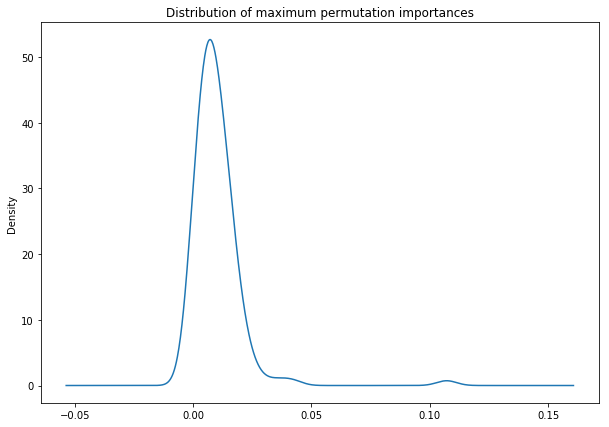

In [72]:
perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances")

The permutation analysis suggests that **none** of the features are important in permuting the prediction. This contradicts the clear separation of the classes in the embedded space. 

It could be that all the features are highly correlated with at least one other feature.

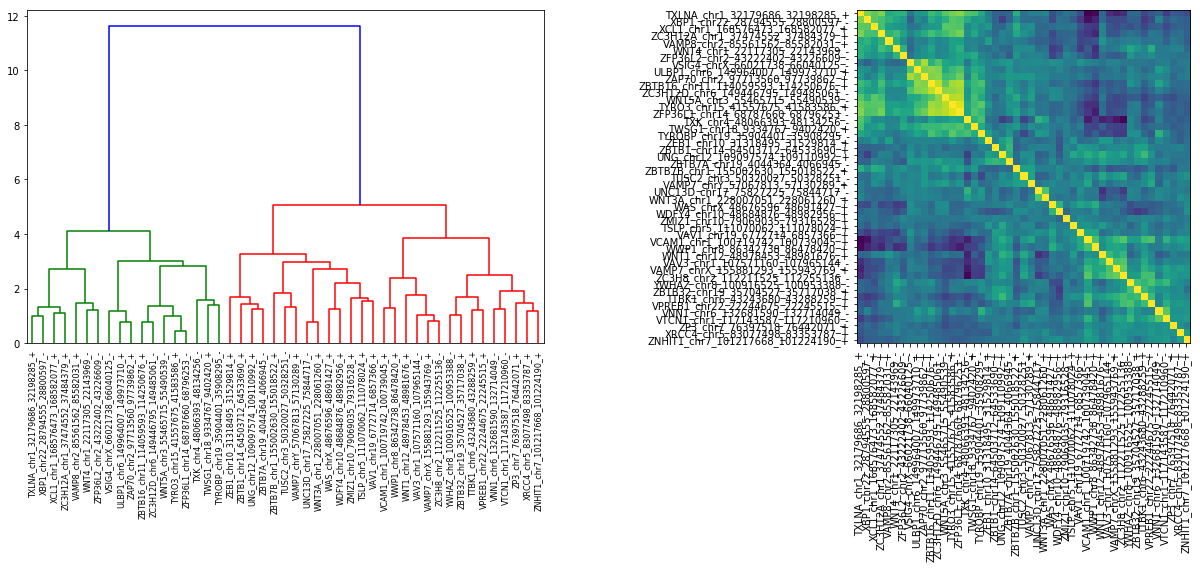

In [64]:

try:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    corr = np.corrcoef(X.T) # 1 - cdist(X.T, X.T, metric='cosine')
    corr_linkage = hierarchy.ward(corr)
    dendro = hierarchy.dendrogram(corr_linkage, labels= rnamap['rnaID'].tolist(), ax=ax1,
                                  leaf_rotation=90)
    dendro_idx = np.arange(0, len(dendro['ivl']))

    ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
    ax2.set_xticks(dendro_idx)
    ax2.set_yticks(dendro_idx)
    ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
    ax2.set_yticklabels(dendro['ivl'])
    fig.tight_layout()
    plt.show()
except Exception as e:
    print("Some problemo: ", e)

    

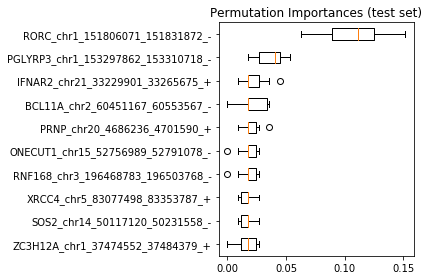

In [77]:
sorted_idx = np.abs(perm_result['XGB'].importances).mean(axis=1).argsort()[-10:]

fig, ax = plt.subplots()
ax.boxplot(perm_result['XGB'].importances[sorted_idx].T,
           vert=False, labels=cols[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [78]:
explainer = TreeExplainer(models['XGB'])
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.


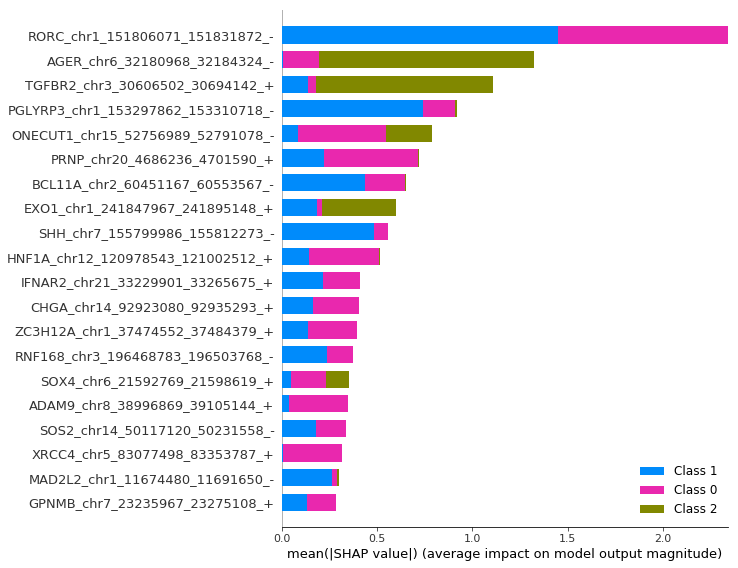

In [79]:
summary_plot(shap_values, cols)

Accuracies of the models:

In [80]:
for _m in models.keys():
    y_pred = models[_m].predict(X_test)
    print("Model:{}, Accuracy:{}".format(_m, balanced_accuracy_score(y_test, y_pred)))

Model:RF, Accuracy:0.9735947712418301
Model:XGB, Accuracy:0.9801307189542484
Model:HB, Accuracy:0.9669281045751634
Model:ET, Accuracy:0.9735947712418301
Model:LGBM, Accuracy:0.9735947712418301
Model:LR, Accuracy:0.9538562091503268
Model:SVM, Accuracy:0.9669281045751634


In [82]:
clust_list['RORC_chr1_151806071_151831872_-']

['PSEN2_chr1_226870184_226896105_+',
 'PLA2G10_chr16_14672545_14694669_-',
 'PARP3_chr3_51942345_51948867_+',
 'FOXJ1_chr17_76136333_76141299_-',
 'STXBP1_chr9_127611760_127692936_+',
 'ENPP3_chr6_131628442_131747418_+',
 'CD46_chr1_207752057_207795513_+',
 'DUSP22_chr6_291630_351355_+',
 'DPP4_chr2_161992241_162074542_-',
 'LFNG_chr7_2512529_2529177_+',
 'KIT_chr4_54657918_54740715_+',
 'GADD45G_chr9_89605013_89606555_+',
 'ERBB2_chr17_39687914_39730426_+',
 'CD151_chr11_832843_839831_+',
 'MUC5B_chr11_1223066_1262172_+',
 'CEACAM6_chr19_41750977_41772208_+',
 'FZD5_chr2_207762586_207769563_-',
 'RORC_chr1_151806071_151831872_-',
 'PRKCD_chr3_53156009_53192717_+',
 'PRKCZ_chr1_2050470_2185395_+']

## 1.1.2 model permutation for survival

To explore whether the survival rate is distinguishable using UMAP-embeddings split the data by cancer type and sample type which seem to be the most discriminative.So we have four groups:
* Adeno normal
* Adeno tumor
* SCC normal
* SCC tumor

In [83]:
Adeno  = RNAex.loc[(RNAex.Diagnosis=='Lung Adenocarcinoma') 
                   & (RNAex['Sample Type']=='Primary Tumor')]
SCC = RNAex.loc[(RNAex.Diagnosis=='Lung Squamous Cell Carcinoma') 
                & (RNAex['Sample Type']=='Primary Tumor')]

ALL = RNAex.loc[(RNAex['Sample Type']=='Primary Tumor')]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Overall Survival Status 0, male')

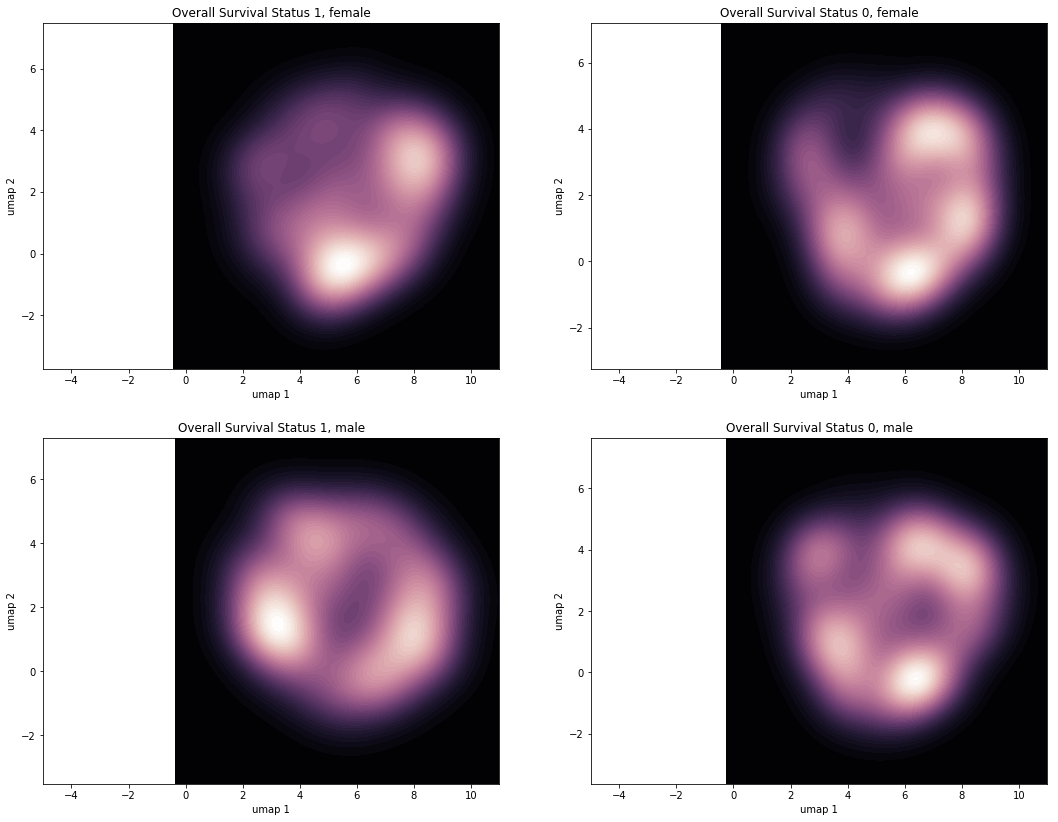

In [84]:
# short exploratory
# 1. dimension reduction
# 2. plot the differential targets

_cols = cols  # rnaID_include

tmp = Adeno
diag_str = 'Adenocarcinoma Overall Survival Status'  # 'Lung Adenocarcinoma' 'Lung Squamous Cell Carcinoma', 'Adeno/SCC'

target = 'Overall Survival Status' # 'Overall Survival Status' # Response # Gender
tmp.dropna(subset=[target], axis=0, inplace=True)

red = 'UMAP'
reduceR = UMAP(n_components=3, random_state=323) #UMAP(n_components=3)

scaler = StandardScaler().fit(tmp.loc[:, _cols])
X = scaler.transform(tmp.loc[:, _cols])

reduceR.fit(X) #  y=tmp['Response']


fig = go.Figure(layout={'title': diag_str+' RNA expression:'+red+' components'})
# Configure the trace.
reduceD = reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==1) & (tmp['Gender']==0), _cols]))
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0], 
    y=reduceD[:,1], 
    z=reduceD[:,2], 
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name= target+' 1, Gender: male'
)
)

reduceD = reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==0) & (tmp['Gender']==0), _cols]))
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  
    y=reduceD[:,1],  
    z=reduceD[:,2], 
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name= target+' 0, Gender: male'
)
)

reduceD = reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==1) & (tmp['Gender']==1), _cols]))
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0], 
    y=reduceD[:,1], 
    z=reduceD[:,2], 
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name= target+' 1, Gender: female'
)
)

reduceD = reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==0) & (tmp['Gender']==1), _cols]))
fig.add_trace(go.Scatter3d(
    x=reduceD[:,0],  
    y=reduceD[:,1],  
    z=reduceD[:,2], 
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.5,
    },
    name= target+' 0, Gender: female'
)
)


# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)
plotly.offline.iplot(fig)

##############
##############

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,14))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)


reduceR = UMAP(n_components=2, random_state=777) #UMAP(n_components=3)
reduceR.fit(X)

reduceD = pd.DataFrame(reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==1) & (tmp['Gender']==1),
                                                               _cols])),
                   columns=['umap 1', 'umap 2'])
sns.kdeplot(reduceD['umap 1'], reduceD['umap 2'], cmap=cmap, n_levels=60, shade=True,  ax=ax[0,0])
ax[0,0].set_xlim(-5, 11)
ax[0,0].set_title(target+' 1, female')

reduceD = pd.DataFrame(reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==0) & (tmp['Gender']==1), 
                                                                  _cols])),
                       columns=['umap 1', 'umap 2'])
sns.kdeplot(reduceD['umap 1'], reduceD['umap 2'], cmap=cmap, n_levels=60, shade=True, ax=ax[0,1])
ax[0,1].set_xlim(-5, 11)
ax[0,1].set_title(target+' 0, female')

############

reduceD = pd.DataFrame(reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==1) & (tmp['Gender']==0),
                                                               _cols])),
                   columns=['umap 1', 'umap 2'])
sns.kdeplot(reduceD['umap 1'], reduceD['umap 2'], cmap=cmap, n_levels=60, shade=True,  ax=ax[1,0])
ax[1,0].set_xlim(-5, 11)
ax[1,0].set_title(target+' 1, male')

reduceD = pd.DataFrame(reduceR.transform(scaler.transform(tmp.loc[(tmp[target]==0) & (tmp['Gender']==0), 
                                                                  _cols])),
                       columns=['umap 1', 'umap 2'])
sns.kdeplot(reduceD['umap 1'], reduceD['umap 2'], cmap=cmap, n_levels=60, shade=True, ax=ax[1,1])
ax[1,1].set_xlim(-5, 11)
ax[1,1].set_title(target+' 0, male')

In [102]:
# 4 class problem: LA/LSCC+survival/response, LA/LSCC+no survival/response
def make_target(x):
    if (x[0]=='Primary Tumor') and (x[1]==1):
        return 'deceased'
    elif (x[0]=='Primary Tumor') and (x[1]==0):
        return 'survived'   
    else:
        np.nan
        
RNAex['y'] = RNAex[['Sample Type' ,'Overall Survival Status']].apply(lambda x:
                                                                                 make_target(x), axis=1)
tmp = RNAex.dropna(subset=['y'])

Smoking                      object
Gender                      float64
Age At Diagnosis (Years)    float64
Stage                        object
dtype: object

In [106]:
with_meta = True
pd.get_dummies()

### Discriminating by survival status for Adenocarcinoma


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting RF
Fitting XGB
Fitting HB
Fitting ET
Fitting LGBM
Fitting LR
Fitting SVM
Getting permutation scores for RF


The max_iter was reached which means the coef_ did not converge


Getting permutation scores for XGB
Getting permutation scores for HB
Getting permutation scores for ET
Getting permutation scores for LGBM
Getting permutation scores for LR
Getting permutation scores for SVM


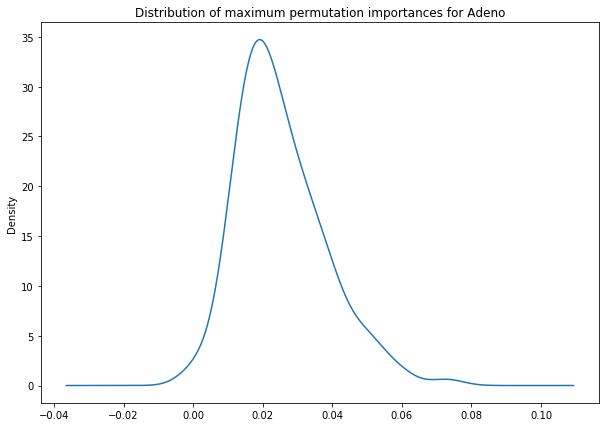

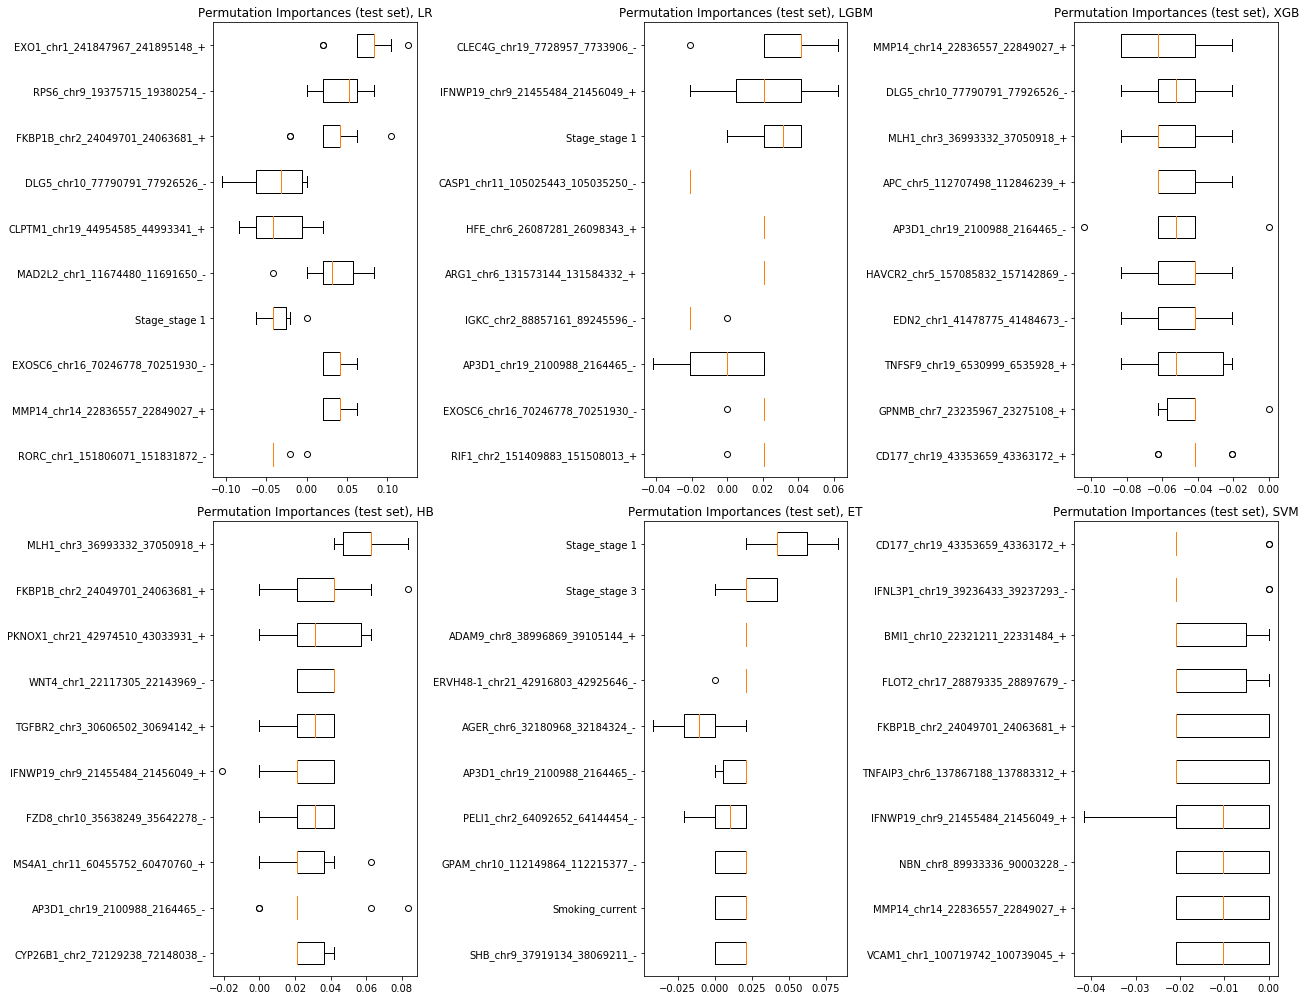

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


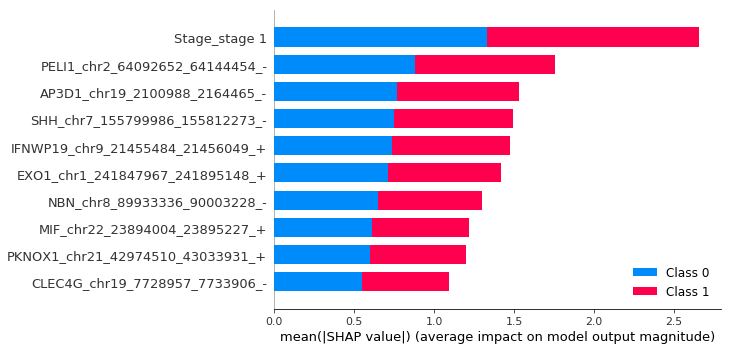

Model:RF, Accuracy:0.5426944971537002
Model:XGB, Accuracy:0.4487666034155598
Model:HB, Accuracy:0.555977229601518
Model:ET, Accuracy:0.5426944971537002
Model:LGBM, Accuracy:0.555977229601518
Model:LR, Accuracy:0.5607210626185959
Model:SVM, Accuracy:0.4971537001897533


In [114]:
if with_meta:
    _cols = list(cols) + ['Smoking', 'Gender', 'Age At Diagnosis (Years)', 'Stage']
    tmp.dropna(subset=['Smoking', 'Gender', 'Age At Diagnosis (Years)', 'Stage'], inplace=True)
    _tmp = pd.get_dummies(tmp[_cols], columns=['Smoking', 'Stage'])
    _cols = np.array(_tmp.columns.tolist())
else:
    _cols = cols

X_adeno = _tmp.loc[tmp.Diagnosis=='Lung Adenocarcinoma', :].values
X_adeno = StandardScaler().fit_transform(X_adeno)
Y_adeno = tmp.loc[tmp.Diagnosis=='Lung Adenocarcinoma', 'y'].values # pd.Categorical(RNAex['y'])
Y_adeno = LabelEncoder().fit(Y_adeno).transform(Y_adeno)

X_train, X_test, y_train, y_test = train_test_split(X_adeno, Y_adeno, 
                                                    random_state=123, stratify=Y_adeno, train_size=0.90)

models = {'RF': RF(n_estimators=500), 
          'XGB': xgb(n_estimators=500), 
          'HB': HB(max_bins=200),
          'ET': ET(n_estimators=1000),
          'LGBM': lgbm(n_estimators=500),
          'LR': LR(penalty='elasticnet', solver='saga', l1_ratio=0.4),
          'SVM': SVC(C=0.9)}
############################################
print('Fitting RF')
models['RF'].fit(X_train, y_train)
print('Fitting XGB')
models['XGB'].fit(X_train, y_train)
print('Fitting HB')
models['HB'].fit(X_train, y_train)
print('Fitting ET')
models['ET'].fit(X_train, y_train)
print('Fitting LGBM')
models['LGBM'].fit(X_train, y_train)
print('Fitting LR')
models['LR'].fit(X_train, y_train)
print('Fitting SVM')
models['SVM'].fit(X_train, y_train)


############################################
perm_result = dict()
print("Getting permutation scores for RF")
perm_result['RF'] = permutation_importance(models['RF'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for XGB")
perm_result['XGB'] = permutation_importance(models['XGB'], X_test, y_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for HB")
perm_result['HB'] = permutation_importance(models['HB'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for ET")
perm_result['ET'] = permutation_importance(models['ET'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LGBM")
perm_result['LGBM'] = permutation_importance(models['LGBM'], X_test, y_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LR")
perm_result['LR'] = permutation_importance(models['LR'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for SVM")
perm_result['SVM'] = permutation_importance(models['SVM'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)
gc.collect()

############################################
tmp_imp = np.vstack([np.abs(perm_result['RF'].importances).mean(axis=1),
           np.abs(perm_result['XGB'].importances).mean(axis=1),
           np.abs(perm_result['HB'].importances).mean(axis=1),
           np.abs(perm_result['ET'].importances).mean(axis=1),      
           np.abs(perm_result['LGBM'].importances).mean(axis=1),
           np.abs(perm_result['LR'].importances).mean(axis=1),
           np.abs(perm_result['SVM'].importances).mean(axis=1)]).transpose()
perm_df = pd.DataFrame(data=tmp_imp, index=_cols, columns=['RF', 'XGB', 'HB', 'ET', 'LGBM', 'LR', 'SVM'])

perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances for Adeno")

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18,14))


sorted_idx = np.abs(perm_result['LR'].importances).mean(axis=1).argsort()[-10:]
ax[0,0].boxplot(perm_result['LR'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,0].set_title("Permutation Importances (test set), LR")

sorted_idx = np.abs(perm_result['LGBM'].importances).mean(axis=1).argsort()[-10:]
ax[0,1].boxplot(perm_result['LGBM'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,1].set_title("Permutation Importances (test set), LGBM")


sorted_idx = np.abs(perm_result['XGB'].importances).mean(axis=1).argsort()[-10:]
ax[0,2].boxplot(perm_result['XGB'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,2].set_title("Permutation Importances (test set), XGB")
################
################
sorted_idx = np.abs(perm_result['HB'].importances).mean(axis=1).argsort()[-10:]
ax[1,0].boxplot(perm_result['HB'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,0].set_title("Permutation Importances (test set), HB")

sorted_idx = np.abs(perm_result['ET'].importances).mean(axis=1).argsort()[-10:]
ax[1,1].boxplot(perm_result['ET'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,1].set_title("Permutation Importances (test set), ET")


sorted_idx = np.abs(perm_result['SVM'].importances).mean(axis=1).argsort()[-10:]
ax[1,2].boxplot(perm_result['SVM'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,2].set_title("Permutation Importances (test set), SVM")


fig.tight_layout()
plt.show()

##############
##############

explainer = TreeExplainer(models['LGBM'])
shap_values = explainer.shap_values(X_adeno)
summary_plot(shap_values, _cols, max_display=10)

##############
##############


for _m in models.keys():
    y_pred = models[_m].predict(X_test)
    print("Model:{}, Accuracy:{}".format(_m, balanced_accuracy_score(y_test, y_pred)))

### Discriminating by survival status for Squamous Cell Carcinoma


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Fitting RF
Fitting XGB
Fitting HB
Fitting ET
Fitting LGBM
Fitting LR
Fitting SVM
Getting permutation scores for RF


The max_iter was reached which means the coef_ did not converge


Getting permutation scores for XGB
Getting permutation scores for HB
Getting permutation scores for ET


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Getting permutation scores for LGBM
Getting permutation scores for LR
Getting permutation scores for SVM


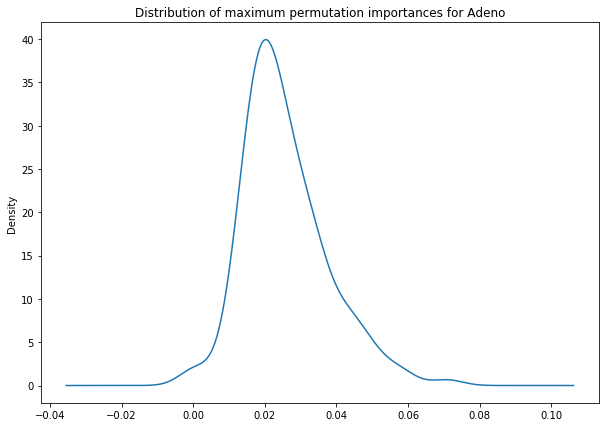

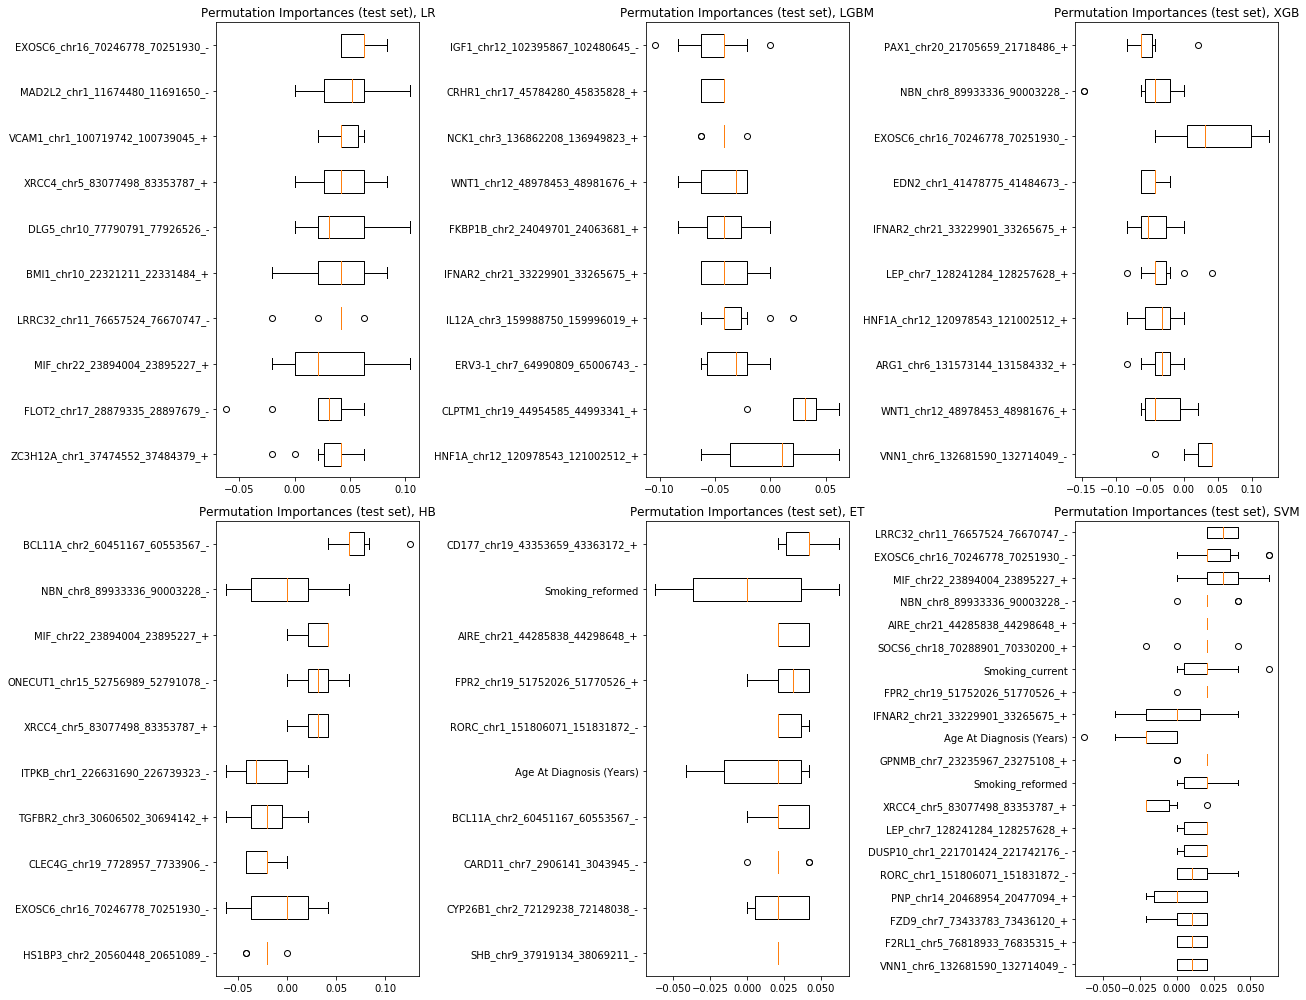

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


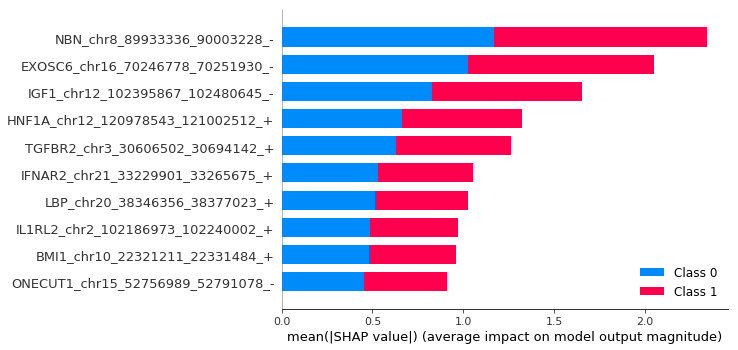

Model:RF, Accuracy:0.4894179894179894
Model:XGB, Accuracy:0.4920634920634921
Model:HB, Accuracy:0.4920634920634921
Model:ET, Accuracy:0.537037037037037
Model:LGBM, Accuracy:0.46825396825396826
Model:LR, Accuracy:0.6613756613756614
Model:SVM, Accuracy:0.4365079365079365


In [115]:
if with_meta:
    _cols = list(cols) + ['Smoking', 'Gender', 'Age At Diagnosis (Years)', 'Stage']
    tmp.dropna(subset=['Smoking', 'Gender', 'Age At Diagnosis (Years)', 'Stage'], inplace=True)
    _tmp = pd.get_dummies(tmp[_cols], columns=['Smoking', 'Stage'])
    _cols = np.array(_tmp.columns.tolist())
else:
    _cols = cols

X_scc = _tmp.loc[tmp.Diagnosis=='Lung Squamous Cell Carcinoma', :].values
X_scc = StandardScaler().fit_transform(X_scc)
Y_scc= tmp.loc[tmp.Diagnosis=='Lung Squamous Cell Carcinoma', 'y'].values # pd.Categorical(RNAex['y'])
Y_scc = LabelEncoder().fit(Y_scc).transform(Y_scc)

X_train, X_test, y_train, y_test = train_test_split(X_scc, Y_scc, 
                                                    random_state=123, stratify=Y_scc, train_size=0.90)

models = {'RF': RF(n_estimators=500), 
          'XGB': xgb(n_estimators=500), 
          'HB': HB(max_bins=200),
          'ET': ET(n_estimators=1000),
          'LGBM': lgbm(n_estimators=500),
          'LR': LR(penalty='elasticnet', solver='saga', l1_ratio=0.5),
          'SVM': SVC(C=0.8)}
############################################
print('Fitting RF')
models['RF'].fit(X_train, y_train)
print('Fitting XGB')
models['XGB'].fit(X_train, y_train)
print('Fitting HB')
models['HB'].fit(X_train, y_train)
print('Fitting ET')
models['ET'].fit(X_train, y_train)
print('Fitting LGBM')
models['LGBM'].fit(X_train, y_train)
print('Fitting LR')
models['LR'].fit(X_train, y_train)
print('Fitting SVM')
models['SVM'].fit(X_train, y_train)


############################################
perm_result = dict()
print("Getting permutation scores for RF")
perm_result['RF'] = permutation_importance(models['RF'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for XGB")
perm_result['XGB'] = permutation_importance(models['XGB'], X_test, y_test, 
                                            n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for HB")
perm_result['HB'] = permutation_importance(models['HB'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for ET")
perm_result['ET'] = permutation_importance(models['ET'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LGBM")
perm_result['LGBM'] = permutation_importance(models['LGBM'], X_test, y_test,
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for LR")
perm_result['LR'] = permutation_importance(models['LR'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)

print("Getting permutation scores for SVM")
perm_result['SVM'] = permutation_importance(models['SVM'], X_test, y_test, 
                                           n_repeats=10, random_state=422, n_jobs=8)
gc.collect()

############################################
tmp_imp = np.vstack([np.abs(perm_result['RF'].importances).mean(axis=1),
           np.abs(perm_result['XGB'].importances).mean(axis=1),
           np.abs(perm_result['HB'].importances).mean(axis=1),
           np.abs(perm_result['ET'].importances).mean(axis=1),      
           np.abs(perm_result['LGBM'].importances).mean(axis=1),
           np.abs(perm_result['LR'].importances).mean(axis=1),
           np.abs(perm_result['SVM'].importances).mean(axis=1)]).transpose()
perm_df = pd.DataFrame(data=tmp_imp, index=_cols, columns=['RF', 'XGB', 'HB', 'ET', 'LGBM', 'LR', 'SVM'])

perm_df.max(axis=1).plot.kde(figsize=(10, 7))
plt.title("Distribution of maximum permutation importances for Adeno")

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18,14))


sorted_idx = np.abs(perm_result['LR'].importances).mean(axis=1).argsort()[-10:]
ax[0,0].boxplot(perm_result['LR'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,0].set_title("Permutation Importances (test set), LR")

sorted_idx = np.abs(perm_result['LGBM'].importances).mean(axis=1).argsort()[-10:]
ax[0,1].boxplot(perm_result['LGBM'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,1].set_title("Permutation Importances (test set), LGBM")


sorted_idx = np.abs(perm_result['XGB'].importances).mean(axis=1).argsort()[-10:]
ax[0,2].boxplot(perm_result['XGB'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[0,2].set_title("Permutation Importances (test set), XGB")
################
################
sorted_idx = np.abs(perm_result['HB'].importances).mean(axis=1).argsort()[-10:]
ax[1,0].boxplot(perm_result['HB'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,0].set_title("Permutation Importances (test set), HB")

sorted_idx = np.abs(perm_result['ET'].importances).mean(axis=1).argsort()[-10:]
ax[1,1].boxplot(perm_result['ET'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,1].set_title("Permutation Importances (test set), ET")


sorted_idx = np.abs(perm_result['SVM'].importances).mean(axis=1).argsort()[-20:]
ax[1,2].boxplot(perm_result['SVM'].importances[sorted_idx].T,
           vert=False, labels=_cols[sorted_idx])
ax[1,2].set_title("Permutation Importances (test set), SVM")


fig.tight_layout()
plt.show()

##############
##############

explainer = TreeExplainer(models['LGBM'])
shap_values = explainer.shap_values(X_scc)
summary_plot(shap_values, _cols, max_display=10)

##############
##############


for _m in models.keys():
    y_pred = models[_m].predict(X_test)
    print("Model:{}, Accuracy:{}".format(_m, balanced_accuracy_score(y_test, y_pred)))

In [116]:
clust_list['EXOSC6_chr16_70246778_70251930_-'], clust_list['NBN_chr8_89933336_90003228_-']

(['AP1G1_chr16_71729000_71809201_-',
  'CBFB_chr16_67029116_67101058_+',
  'EXOSC6_chr16_70246778_70251930_-'],
 ['WWP1_chr8_86342738_86478420_+',
  'NBN_chr8_89933336_90003228_-',
  'FAM49B_chr8_129839593_130017129_-',
  'RIPK2_chr8_89757747_89791063_+'])

## 1.1.3 model permutation for time to event

How to use survival curves instead of the overall survival status? 

We cannot directly use the survival curves but we can apply use the ```Time To Event From Diagnosis (Days)``` to train a regressor.



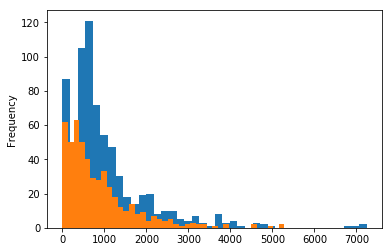

In [117]:
meta.loc[meta['Overall Survival Status']==0, 'Time To Overall Survival (Days)'].plot.hist(bins=40)
meta.loc[meta['Overall Survival Status']==1, 'Time To Overall Survival (Days)'].plot.hist(bins=40)

Here a survival status of ```1``` actually means death, and ```0``` means survived. The time to overall survival is more the time to recovery for the survivors, and the time to death for the non-survivors. 

We need to make a choice, do we regress on the time-to-recovery or the time-to-death.
* time-to-recovery: for the non-survivors we should set the recovery time to a large number?
* time-to-death: for the survivors, we should set the time to death to a large number depending on their age?

**or** do we segment the data in survivors and deceasers, this avoids the issue of a non-realistic definition for the time to recovery/death. We choose for the latter and split the dataset.

In [213]:
pheno_features = ['Diagnosis', 'Sample Type', 
                  'Gender', 'Age At Diagnosis (Days)',
                  'Stage', 'Smoking', 'Time To Overall Survival (Days)']
patients_survived = meta.loc[meta['Overall Survival Status']==0, pheno_features]
patients_deceased = meta.loc[meta['Overall Survival Status']==1, pheno_features]

patients_survived.dropna(subset=pheno_features, inplace=True)
patients_deceased.dropna(subset=pheno_features, inplace=True)

patients_survived = patients_survived[pheno_features]
patients_deceased = patients_deceased[pheno_features]

In [214]:
patients_deceased = pd.get_dummies(patients_deceased, prefix='dummy_', columns=['Diagnosis', 'Sample Type', 'Stage', 
                                                            'Smoking'])

patients_survived = pd.get_dummies(patients_survived, prefix='dummy_', columns=['Diagnosis', 'Sample Type', 'Stage', 
                                                            'Smoking'])

In [278]:
tmp_cols = cols # cols, rnaID_include
rna_tmp = RNAex.loc[:, tmp_cols].dropna()

X_deceased = patients_deceased.join(rna_tmp, how='inner')
X_survived = patients_survived.join(rna_tmp, how='inner')
_cols = np.array(X_deceased.columns.tolist())

y_deceased = X_deceased['Time To Overall Survival (Days)']
y_survived = X_survived['Time To Overall Survival (Days)']

X_deceased.drop('Time To Overall Survival (Days)', axis=1, inplace=True)
X_survived.drop('Time To Overall Survival (Days)', axis=1, inplace=True)

In [ ]:
X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_survived, y_survived, 
                                                            random_state=123, train_size=0.90)

In [298]:
X_survived.dtypes[:20]

Gender                                   int64
Age At Diagnosis (Days)                float64
dummy__Lung Adenocarcinoma               uint8
dummy__Lung Squamous Cell Carcinoma      uint8
dummy__FFPE Scrolls                      uint8
dummy__Primary Tumor                     uint8
dummy__Recurrent Tumor                   uint8
dummy__Solid Tissue Normal               uint8
dummy__stage 1                           uint8
dummy__stage 2                           uint8
dummy__stage 3                           uint8
dummy__stage 4                           uint8
dummy__current                           uint8
dummy__non-smoker                        uint8
dummy__reformed                          uint8
CD177_chr19_43353659_43363172_+        float64
IL13RA2_chrX_115003975_115019977_-     float64
IL12A_chr3_159988750_159996019_+       float64
AIRE_chr21_44285838_44298648_+         float64
FZD9_chr7_73433783_73436120_+          float64
dtype: object

In [2]:
# XGB, LGBM, SVR, NGB, GAM, Huber, ElasticNet, MARS
models = dict()
models['gam'] = LinearGAM(f(0)
                          +s(1, constraints='monotonic_inc')
                          +f(2)+f(3)+f(4)+f(5)+f(6)+f(7)+f(8)+f(9)+f(10)+f(11)+f(12)+f(13)+f(14)
                          +s(15, constraints='monotonic_inc'))
models['ebr'] = ebr()
models['huber'] = HuberRegressor()
models['enet'] = ElasticNet()
models['mars'] = Earth()
models['xgb'] = xgbr(n_estimators=200)
models['lgbm'] = lgbmr(n_estimators=200)
models['ngb'] = ngbr(Dist=Normal) # LogNormal, Bernoulli, Normal

### GAM

MSE: 680698.602375506


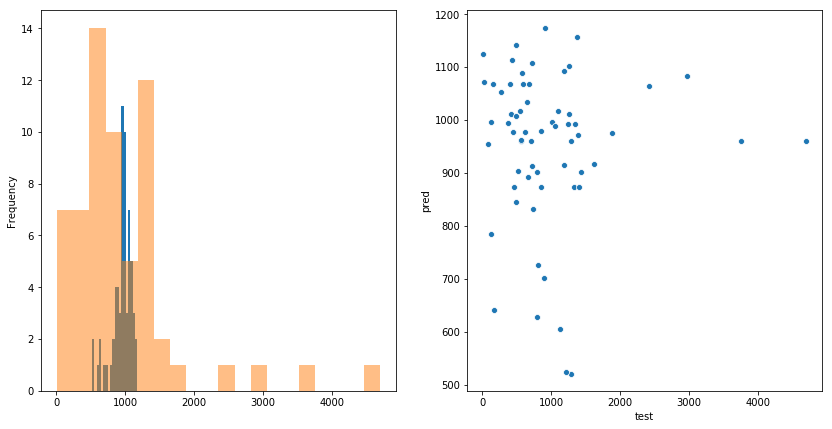

In [349]:
models['gam'].fit(X_s_train, y_s_train)
gam_res = pd.DataFrame(data=np.vstack([models['gam'].predict(X_s_test),
                                       y_s_test.values]).T, columns=['pred', 'test'])

fig, ax = plt.subplots(ncols=2, figsize=(14,7))
gam_res['pred'].plot.hist(bins=20, ax=ax[0])
gam_res['test'].plot.hist(bins=20, alpha=0.5, ax=ax[0])

sns.scatterplot(data=gam_res, x='test', y='pred')

print("MSE:", mean_squared_error(gam_res['pred'], xgb_res['test']))

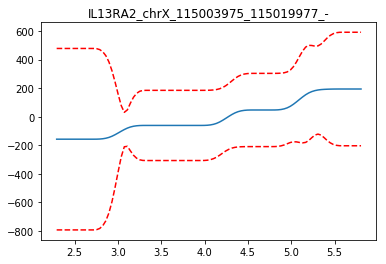

In [352]:
gam_terms = models['gam'].terms
feature_idx=15
XX = models['gam'].generate_X_grid(term=feature_idx)
pdep, confi = models['gam'].partial_dependence(term=feature_idx, X=XX, width=0.95)

plt.figure()
plt.plot(XX[:, gam_terms[feature_idx].feature], pdep)
plt.plot(XX[:, gam_terms[feature_idx].feature], confi, c='r', ls='--')
plt.title(_cols[feature_idx])
plt.show()

### EBR

In [3]:
models['ebr'].fit(X_s_train, y_s_train)

NameError: name 'X_s_train' is not defined

In [258]:
shap_values = TreeExplainer(models['gam']).shap_values(X_s_train)
shap.summary_plot(shap_values, _cols)

SHAPError: Model type not yet supported by TreeExplainer: <class 'pygam.pygam.LinearGAM'>